In [1]:
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Hyperparameters

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = False

# Hyperparameters
FOLDS = 21 if PRODUCTION else 2   # Only 5 or 10.
EPOCHS = 121        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'selu' # swish mish relu selu ;swish seem to work better with binary classification only?
KERNEL_INIT = "lecun_normal" # Minimal impact, but give your init the right foot forward glorot_uniform
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.7   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 19  # Early stopping
DROPOUT = 0.1     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [192, 128, 128, 64]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 2262087 if PRODUCTION else 11426   # True for FULL run. Max Sample size per category. For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"            # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = True

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

# Misc functions

In [3]:
def plot_acc(history_f):
    fold = 0
    best_epoch = np.argmin(np.array(history_f['val_loss']))
    best_val_loss = history_f['val_loss'][best_epoch]

    fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

    fig.suptitle('Fold : '+ str(fold+1) +
                 " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                 " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                 " LR: {:0.8f}".format(history_f['lr'].min())
                 , fontsize=14)

    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])

    from_epoch = 0
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_loss], c = 'r', label = f'Best val_loss = {best_val_loss:.5f}')
    if best_epoch > 0:
        almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
        almost_val_loss = history_f['val_loss'][almost_epoch]
        if almost_epoch >= from_epoch:
            plt.scatter([almost_epoch], [almost_val_loss], c='orange', label = 'Second best val_loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')   

    ax2 = plt.gca().twinx()
    ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
    ax2.set_ylabel('Learning rate')
    ax2.legend(loc = 'upper right')
    ax2.grid()

    best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
    best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]

    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
    if best_epoch >= from_epoch:
        plt.scatter([best_epoch], [best_val_acc], c = 'r', label = f'Best val_acc = {best_val_acc:.5f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'lower left')
    plt.legend(fontsize = 15)
    plt.grid(b = True, linestyle = '-')


# Load dataset

In [4]:
# load the dataset
def load_dataset():
    return make_classification(
        n_samples=1000,
        n_features=15,
        n_informative=3,
        n_redundant=2,
        n_repeated=0,
        n_classes=8,
        n_clusters_per_class=1,
        random_state=0,
    )

X, y = load_dataset()

# Plot

C:\Users\furyx\miniconda3\envs\tf27\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Two informative features, one cluster per class'}>

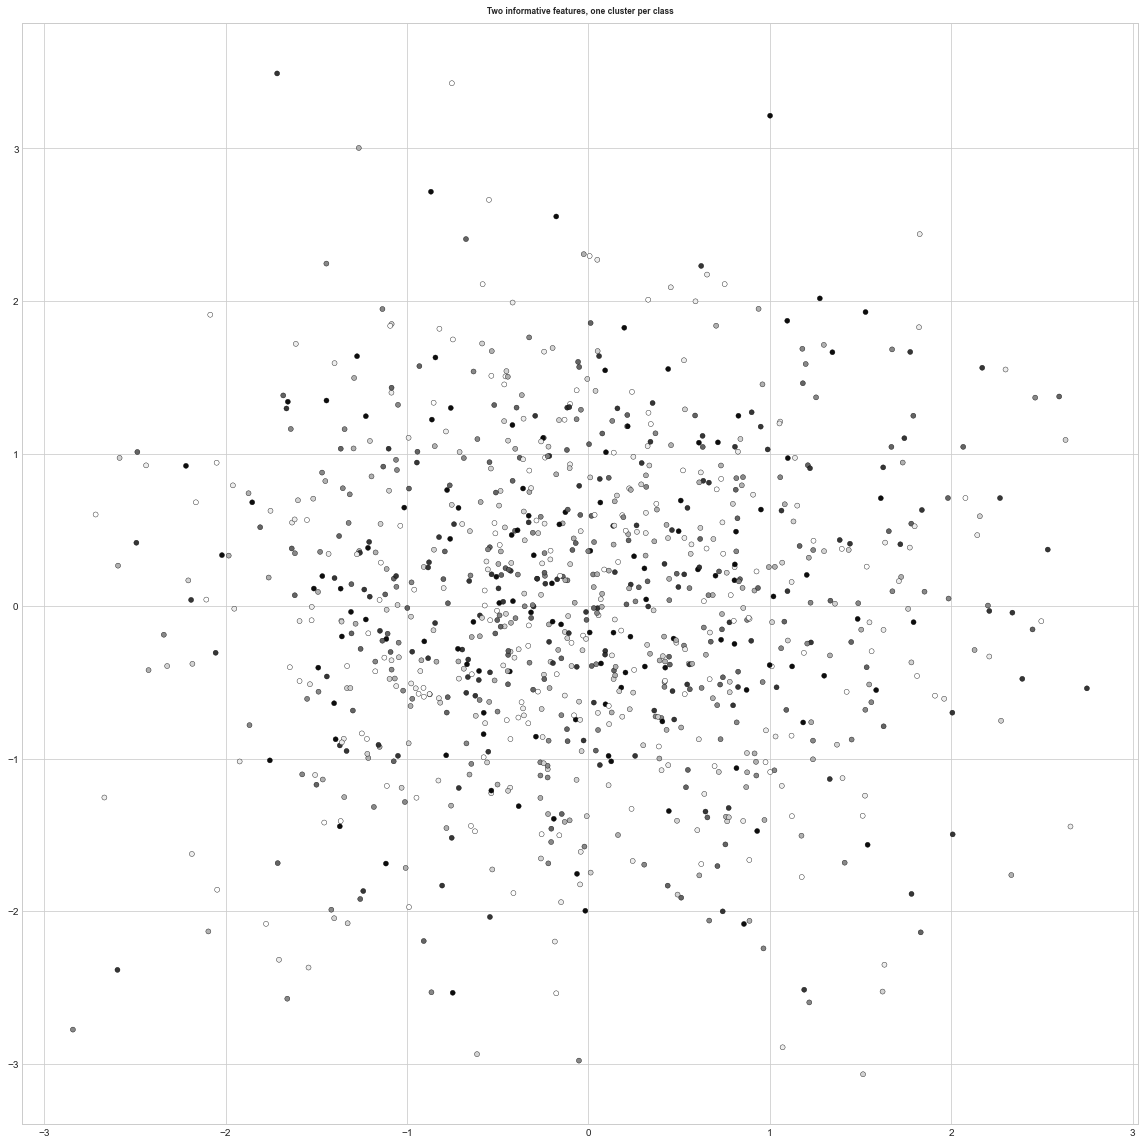

In [6]:
plt.figure(figsize=(16, 16))

plt.title("Two informative features, one cluster per class", fontsize="small")

sns.scatterplot(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k", alpha=0.95, palette="deep")

# Transform

In [7]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y = le.fit_transform(y) # y to categorical

In [ ]:
# train, val = train_test_split(X, test_size=VALIDATION_SPLIT, stratify=X[[TARGET_FEATURE_NAME]], random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Features Configs

In [8]:
# TARGET_FEATURE_NAME = column_y
TARGET_FEATURE_LABELS = np.unique(y)
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

In [9]:
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)
print(np.unique(y, return_counts=True))

15
8
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([129, 126, 124, 124, 122, 125, 129, 121], dtype=int64))


# Models

In [ ]:
modelCheckpoint = None

if TPU:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    modelCheckpoint = ModelCheckpoint(  'best_model', options = save_locally,
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )
else:
    modelCheckpoint = ModelCheckpoint(
                                        'best_model',
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )

early_stopping = EarlyStopping(
        patience = ES_PATIENCE,
        min_delta = MIN_DELTA,
        monitor = ACC_VAL_METRICS,
        mode = 'max',
        restore_best_weights = True,       
        baseline = None,
        verbose = VERBOSE,
    )
plateau = ReduceLROnPlateau(
        patience = RLRP_PATIENCE,
        factor = LR_FACTOR,
        min_lr = 1e-7,
        monitor = 'val_loss', 
        mode = 'min',
        verbose = VERBOSE,
    )

In [10]:
def get_MLPmodel(**kwargs):
# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    model = keras.Sequential([
#     layers.BatchNormalization(input_shape = [X.shape[-1]], name = 'input'),
    layers.Dense(units = 300, input_shape = [INPUT_SHAPE], name = 'input', kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 200, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 100, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 50, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output'), #y_cat.shape[-1]
    ])

    return model

In [11]:
class MCDropout(keras.layers.Dropout):
    '''Boost the performance of any trained dropout model without having to retrain it or even modify it at all.
        Provide a much better measure of the models uncertainty'''
    def call(self, inputs):
        return super().call(inputs, training=True)

class Standardization(layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation = ACTIVATION, dropout_rate = 0, l2 = 0, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.dense = layers.Dense(
            units = units, 
#             activation = activation,
            kernel_initializer = KERNEL_INIT, 
#             kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
        if dropout_rate > 0:
            self.dropout = layers.Dropout(rate = dropout_rate) #MCDropout
        else:
            self.dropout = None
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation(x)
        x = self.batchn(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x

# create fully-connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.hidden_layers = [DenseBlock(units = units,
                                         activation = activation,
                                         dropout_rate = dropout_rate,
                                         l2 = l2
                                        )
                              for units in hidden_layers
                             ]
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        x = inputs
        for dense_layer in self.hidden_layers:
            x = dense_layer(x)
        x = self.softmax(x)
        return x

In [12]:
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(CrossNet, self).__init__(**kwargs)

        for i, units in enumerate(hidden_layers, start=1):
            if i == 1: # Dropout before last layer only len(hidden_layers)
                self.dense_layers = [DenseBlock(units = units, activation = activation, dropout_rate = dropout_rate, l2 = l2)]
            else:
                self.dense_layers.append(DenseBlock(units = units, activation = activation, dropout_rate = 0, l2 = l2))
        
        self.dense = layers.Dense(units = INPUT_SHAPE)
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        
        dense, cross = inputs, inputs
        
        for dense_layer in self.dense_layers:
            # Deep net TODO only dropout at last layer
            dense = dense_layer(dense)
            # Parrallel Cross net
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
            
        cross = self.batchn(cross)
        
        merged = self.concat([dense, cross])
        return self.softmax(merged)

In [13]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [14]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [15]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)


class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelection, self).__init__(**kwargs)
        self.grns = list()
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs


In [16]:
def encode_vsn_inputs(inputs, encoding_size):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features


def create_grn_and_vsn_model(encoding_size, dropout_rate=DROPOUT):
    inputs = layers.Input(len(X.columns))
    feature_list = encode_vsn_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [29]:
def build_models(models):
    for model in models:
        model.compile(
            optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
        )


In [39]:
def fit_models(models, historys, X_test, y_test, X_valid, y_valid)):
    for model in models:
        history=model.fit(X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE,
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau,  # tensorboard_callback
                                  ],
                shuffle = True,
                verbose = VERBOSE,
              )
        historys.append(history)

In [47]:
def evaluate_models(models, historys, X_test=X_test, y_test=y_test):
    for model, history in zip(models, historys):
        model.summary()
        _, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        print('Accuracy: %.2f' % (accuracy*100))
        plot_acc(pd.DataFrame(history.history))


In [52]:
def predict_models(models, X_test):
    for model in models:
        predict_hat = model.predict(X_test, verbose=VERBOSE)
        print(f'predict_hat: {predict_hat}')

In [42]:
models = []
historys = []

In [43]:
model_MLP = MLP(
    hidden_layers=HIDDEN_LAYERS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT
)
models.append(model_MLP)


In [44]:
model_CrossNet = CrossNet(
    hidden_layers=HIDDEN_LAYERS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT
)
models.append(model_CrossNet)


Model: "mlp_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_block_16 (DenseBlock)  multiple                 3840      
                                                                 
 dense_block_17 (DenseBlock)  multiple                 25216     
                                                                 
 dense_block_18 (DenseBlock)  multiple                 17024     
                                                                 
 dense_block_19 (DenseBlock)  multiple                 8512      
                                                                 
 output (Dense)              multiple                  520       
                                                                 
Total params: 55,112
Trainable params: 54,088
Non-trainable params: 1,024
_________________________________________________________________
Accuracy: 76.00
Model: "cross_net_1"
________________

C:\Users\furyx\AppData\Local\Temp/ipykernel_31524/1664447733.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


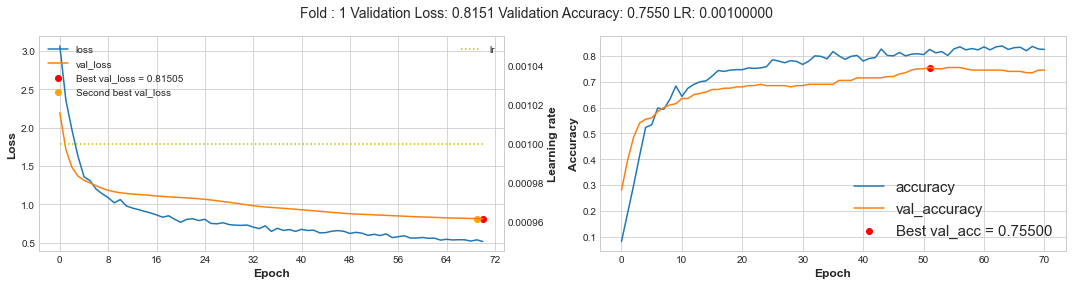

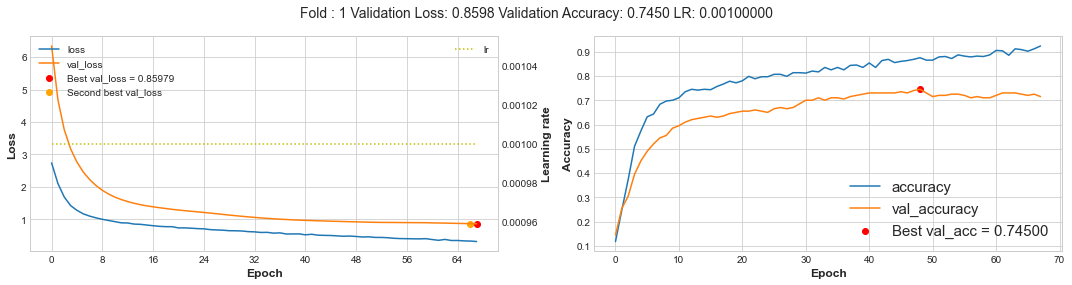

In [45]:
build_models(models=models)
fit_models(models=models, historys=historys, X_test=X_test, y_test=y_test, X_valid=X_valid, y_valid=y_valid))
evaluate_models(models = models, historys = historys,
                X_test = X_test, y_test = y_test)



In [53]:
predict_models(models = models, X_test = X_test)

predict_hat: [[2.6820954e-03 2.5186066e-05 3.9574620e-06 ... 5.0499961e-03
  6.6469600e-03 4.1412368e-05]
 [2.0299055e-06 1.2593462e-07 2.1386196e-01 ... 7.6940279e-07
  7.7528059e-01 3.5122761e-03]
 [4.0896019e-04 2.1904709e-06 2.9484245e-06 ... 8.5443130e-04
  3.2338060e-02 7.0231567e-06]
 ...
 [3.3403914e-05 3.0577782e-04 9.9949050e-01 ... 5.2948237e-09
  2.7807251e-05 1.3072524e-06]
 [9.4964480e-06 1.9752342e-02 4.1261881e-08 ... 9.7279257e-01
  1.6561435e-07 6.1005221e-07]
 [1.1330676e-05 1.5384688e-04 4.2309612e-04 ... 6.5309300e-06
  7.3831784e-06 3.7120812e-04]]
predict_hat: [[6.9523780e-03 3.3312637e-05 9.6406402e-06 ... 2.8659585e-03
  9.1639068e-03 4.8512557e-05]
 [4.9020964e-05 9.0711801e-05 1.0645062e-01 ... 8.6993714e-06
  8.8464230e-01 5.2062403e-03]
 [1.9646201e-03 5.2876194e-06 1.3886811e-05 ... 1.2288798e-03
  1.1175539e-02 2.9581550e-05]
 ...
 [1.5522478e-04 1.3882311e-03 9.9834514e-01 ... 2.4077154e-08
  1.5759931e-06 1.4968093e-06]
 [1.9909901e-05 1.5837617e-02 7.5

In [88]:
X_test[:1]

array([[-0.24184295,  0.34705546, -0.93307683, -0.50611494, -0.79074497,
        -0.89535304, -1.23021147, -1.23767225,  0.53534564, -0.78736427,
        -0.96524665, -0.04756206, -0.28085156,  0.08297869,  0.68926277]])

In [89]:
models[0].predict(X_test[:1])

array([[2.6820889e-03, 2.5185995e-05, 3.9574543e-06, 5.5945713e-07,
        9.8554987e-01, 5.0499840e-03, 6.6469442e-03, 4.1412171e-05]],
      dtype=float32)